In [1]:
# Modules
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import inspect
import warnings
import pygam

from sklearn import ensemble, metrics, model_selection, preprocessing, tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
def display_roc(fp_rates:np.ndarray, tp_rates:np.ndarray, thresholds:np.ndarray, best_index:int=None) -> None:
    '''Displays ROC curve and AUC'''
    auc     = metrics.auc(fp_rates, tp_rates)
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(fp_rates, tp_rates, color='blue', label=f'AUC: {auc:0.4f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='dashed')
    if best_index is not None:
        ax.scatter(fp_rates[best_index], tp_rates[best_index], marker='o', c='lightgreen', s=7.5**2, edgecolor='black', zorder=2, label=f'Threshold: {thresholds[best_index]:0.4f}')
    ax.set_title('Receiver operating characteristic')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc='lower right', frameon=False)
    pyplot.tight_layout()
    pyplot.show()

def display_history(history:dict, stat:str='loss', validation:bool=False) -> None:
    '''Displays training history for a statistic'''
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(history[stat], label='Training sample')
    if validation:
        ax.plot(history[f'val_{stat}'], label='Validation sample')
    ax.set_title(f'Model training', fontsize=15)
    ax.set_ylabel(stat.title())
    ax.set_xlabel('Epoch')
    ax.legend(frameon=False)
    pyplot.tight_layout()
    pyplot.show()
    
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

## Random Forest

In [3]:
# Import the data
df_selected = pd.read_csv('Data_selection.csv')

##### 1.1 Initial Fitting on data set with preliminary feature selection

In [4]:
df = df_selected

# Randomly split the data set into training and testing and deal with the imbalanced dependent variable using SMOTE
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size = 0.75, shuffle = True, random_state = 480)

undersampler = RandomUnderSampler(random_state=480)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Fit a random forest model with 25 trees to the training data
ForestModel = RandomForestClassifier(n_estimators = 25, random_state = 480, n_jobs = -1)
ForestModel.fit(X_train_resampled, y_train_resampled)

# make predictions on the training and test sets
y_pred_train = ForestModel.predict(X_train_resampled)
y_pred_test = ForestModel.predict(X_test)

# compute in-sample performance metrics
accuracy_train = metrics.accuracy_score(y_train_resampled, y_pred_train)
precision_train = metrics.precision_score(y_train_resampled, y_pred_train)
recall_train = metrics.recall_score(y_train_resampled, y_pred_train)
f1_score_train = metrics.f1_score(y_train_resampled, y_pred_train)
roc_auc_train = metrics.roc_auc_score(y_train_resampled, y_pred_train)

# compute out-of-sample performance metrics
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
precision_test = metrics.precision_score(y_test, y_pred_test)
recall_test = metrics.recall_score(y_test, y_pred_test)
f1_score_test = metrics.f1_score(y_test, y_pred_test)
roc_auc_test = metrics.roc_auc_score(y_test, y_pred_test)

# assuming you have already computed the performance metrics
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
        'Training': [accuracy_train, precision_train, recall_train, f1_score_train, roc_auc_train],
        'Test': [accuracy_test, precision_test, recall_test, f1_score_test, roc_auc_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,Accuracy,0.999328,0.641302
1,Precision,0.999194,0.135253
2,Recall,0.999462,0.636188
3,F1-score,0.999328,0.223080
4,ROC AUC,0.999328,0.638970


In [5]:
rmse_train = mean_squared_error(y_train_resampled, y_pred_train, squared = False)
mae_train = mean_absolute_error(y_train_resampled, y_pred_train)

rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
mae_test = mean_absolute_error(y_test, y_pred_test)

data = {'Metric': ['RMSE', 'MAE'],
        'Training': [rmse_train, mae_train],
        'Test': [rmse_test, mae_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,RMSE,0.025922,0.598914
1,MAE,0.000672,0.358698


##### 1.2 Hyperparameter Tuning using Cross-validation on data set with preliminary feature selection

In [8]:
# define the parameter grid
param_grid = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(10, 21, 1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# create a random forest model
rf = RandomForestClassifier(random_state=480, n_estimators = 100, max_depth = 12, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', n_jobs = -1)

# create a grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# fit the grid search object to the data
grid_search.fit(X_train_resampled, y_train_resampled)

print(grid_search.best_params_)

KeyboardInterrupt: 

##### 1.3 Refit the model using optimal parameters found through hyperparameter tuning on data set with preliminary feature selection

In [6]:
rf = RandomForestClassifier(random_state=480, n_estimators = 100, max_depth = 12, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', n_jobs = -1)

# fit the model to the training data
rf.fit(X_train_resampled, y_train_resampled)

# make predictions on the training and test sets
y_pred_train = rf.predict(X_train_resampled)
y_pred_test = rf.predict(X_test)

# compute in-sample performance metrics
accuracy_train = metrics.accuracy_score(y_train_resampled, y_pred_train)
precision_train = metrics.precision_score(y_train_resampled, y_pred_train)
recall_train = metrics.recall_score(y_train_resampled, y_pred_train)
f1_score_train = metrics.f1_score(y_train_resampled, y_pred_train)
roc_auc_train = metrics.roc_auc_score(y_train_resampled, y_pred_train)

# compute out-of-sample performance metrics
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
precision_test = metrics.precision_score(y_test, y_pred_test)
recall_test = metrics.recall_score(y_test, y_pred_test)
f1_score_test = metrics.f1_score(y_test, y_pred_test)
roc_auc_test = metrics.roc_auc_score(y_test, y_pred_test)

# assuming you have already computed the performance metrics
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'],
        'Training': [accuracy_train, precision_train, recall_train, f1_score_train, roc_auc_train],
        'Test': [accuracy_test, precision_test, recall_test, f1_score_test, roc_auc_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,Accuracy,0.773143,0.662543
1,Precision,0.775154,0.145706
2,Recall,0.769487,0.651615
3,F1-score,0.772310,0.238158
4,ROC AUC,0.773143,0.657560


In [7]:
rmse_train = mean_squared_error(y_train_resampled, y_pred_train, squared = False)
mae_train = mean_absolute_error(y_train_resampled, y_pred_train)

rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
mae_test = mean_absolute_error(y_test, y_pred_test)

data = {'Metric': ['RMSE', 'MAE'],
        'Training': [rmse_train, mae_train],
        'Test': [rmse_test, mae_test]}
df = pd.DataFrame(data)
df

,Metric,Training,Test
0,RMSE,0.476295,0.580910
1,MAE,0.226857,0.337457


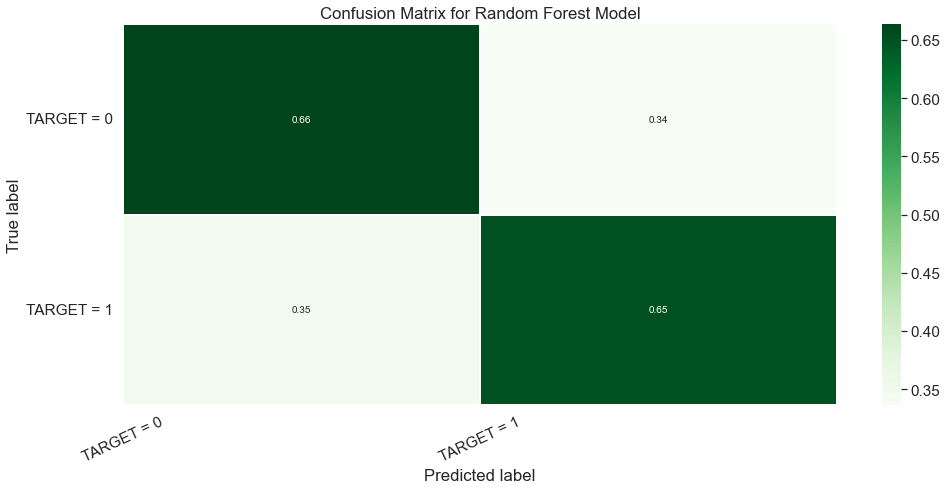

In [8]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
pyplot.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=pyplot.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['TARGET = 0', 'TARGET = 1']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
pyplot.xticks(tick_marks, class_names, rotation=25)
pyplot.yticks(tick_marks2, class_names, rotation=0)
pyplot.xlabel('Predicted label')
pyplot.ylabel('True label')
pyplot.title('Confusion Matrix for Random Forest Model')
pyplot.show()

In [9]:
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

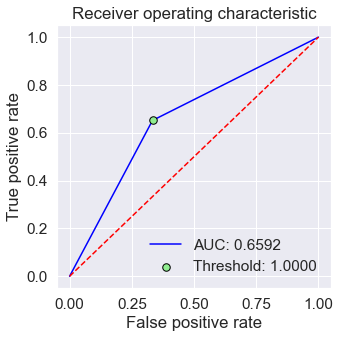

In [10]:
# ROC curve
yh_test = np.squeeze(rf.predict(X_test_resampled))
fp_rates, tp_rates, thresholds = metrics.roc_curve(y_test_resampled, yh_test)
youden = np.argmax(tp_rates - fp_rates)
display_roc(fp_rates, tp_rates, thresholds, youden)

In [11]:
# Calculate feature importance
importances = rf.feature_importances_

# Create a DataFrame to store the results
importance_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': importances})

# Sort the DataFrame by importance and select the top 10 features
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the results
importance_df

,Feature,Importance
6,FLAG_CONT_MOBILE,0.209361
37,DAYS_BIRTH,0.084859
38,AMT_GOODS_PRICE,0.064751
15,REG_REGION_NOT_LIVE_REGION,0.061897
17,FLAG_EMAIL,0.059932
13,REG_CITY_NOT_LIVE_CITY,0.054481
1,DAYS_REGISTRATION,0.052453
10,FLAG_WORK_PHONE,0.028999
7,REG_REGION_NOT_WORK_REGION,0.026668
14,LIVE_REGION_NOT_WORK_REGION,0.025630


In [12]:
# get feature importances
importances = rf.feature_importances_

# get indices of top 10 features
indices = np.argsort(importances)[::-1][:10]

# calculate partial dependence
fig, ax = pyplot.subplots(2, 5, figsize=(20, 5))
pdp_results = PartialDependenceDisplay.from_estimator(rf, X_train_resampled, indices,
                                                      feature_names=X_train_resampled.columns,
                                                      ax=ax.ravel())
# reduce the font size of the titles
for ax in pdp_results.axes_.ravel():
    ax.set_title(ax.get_title(), fontsize=5)
    
pyplot.tight_layout()

NameError: name 'ax' is not defined

NameError: name 'plt' is not defined

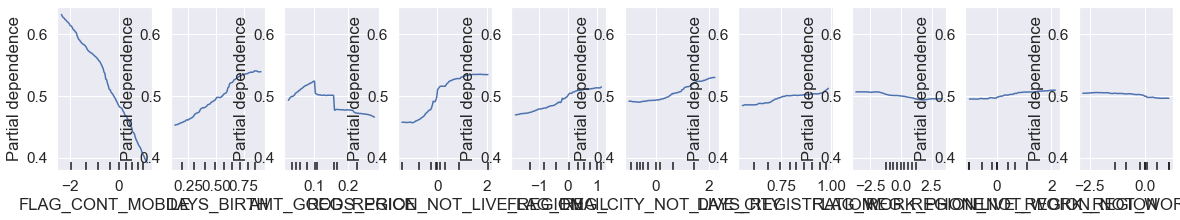

In [15]:
# Get feature importances
importances = rf.feature_importances_

# Get indices of top 10 features
indices = np.argsort(importances)[::-1][:10]

# Calculate partial dependence
fig, ax = pyplot.subplots(1, 10, figsize=(20, 3))
pdp_results = PartialDependenceDisplay.from_estimator(rf, X_train_resampled, indices,
                                                      feature_names=X_train_resampled.columns,
                                                      ax=ax)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Set the background color and border color for all plots
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'

# Remove internal grid lines within each plot
for axes_row in pdp_results.axes_:
    for axes in axes_row:
        axes.grid(False)

# Set black border around each plot
for axes in pdp_results.axes_.ravel():
    axes.spines['top'].set_color('black')
    axes.spines['right'].set_color('black')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')

# Reduce the font size of the titles
for axes in pdp_results.axes_.ravel():
    axes.set_title(axes.get_title(), fontsize=10)

pyplot.show()
